In [1]:
from mcculw import ul
from mcculw.enums import InterfaceType
from mcculw.device_info import DaqDeviceInfo
from mcculw.enums import ULRange,AnalogInputMode
import time
import numpy as np
from matplotlib import pyplot as plt
import json
import matplotlib.cm as cm
import pandas as pd

In [2]:
colors = ['tab:red', 'tab:orange', 'tab:olive', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:brown']

In [3]:
AI_name = 'USB-1608G'
AO_name = 'USB-3105'

In [4]:
ul.ignore_instacal()
devices = ul.get_daq_device_inventory(InterfaceType.ANY)

if not devices:
        raise Exception('Error: No DAQ devices found')

for d in devices:
    if d.product_name == AI_name:
        AI = d
    elif d.product_name == AO_name:
        AO = d

In [5]:
in_num = 0
ul.create_daq_device(in_num, AI)

out_num=1
ul.create_daq_device(out_num, AO)

In [6]:
#set ranges

ai_range = ULRange.BIP10VOLTS 
ai_range_Vr = ULRange.BIP1VOLTS 
ul.a_input_mode(in_num, AnalogInputMode.SINGLE_ENDED) # SE mode

daq_dev_info = DaqDeviceInfo(out_num)
ao_range = daq_dev_info.get_ao_info().supported_ranges[0]

In [7]:
out_V0_ch = 11
out_LED_ch = 13

out_Vg1_ch = 5
out_Vg2_ch = 7
out_Vg3_ch = 9
out_Vg4_ch = 0
out_Vg5_ch = 2
out_Vg6_ch = 4
out_Vg7_ch = 6
out_Vg8_ch = 8
out_Vg9_ch = 10
in_V0_ch = 7
in_V1_ch = 0
in_V2_ch = 1
in_V3_ch = 9
in_V4_ch = 2
in_V5_ch = 10
in_V6_ch = 3
in_V7_ch = 11
in_V8_ch = 14
in_V9_ch = 6
in_Vr_ch = 15

R0 = 998 #shunt resistance
GND = 0 #V
LED_supply = 3 #V
gain = 1.

Vg1 = 2.5
Vg2 = 2.55
Vg3 = 2.62
Vg4 = 2.63
Vg5 = 2.60
Vg6 = 2.45
Vg7 = 2.4
Vg8 = 2.47
Vg9 = 2.47

edgecomms = pd.DataFrame({'edge': pd.Series([1,2,3,4,5,6,7,8,9], dtype='int'), 
                          'out_Vg': pd.Series([out_Vg1_ch, out_Vg2_ch, out_Vg3_ch, out_Vg4_ch, out_Vg5_ch, out_Vg6_ch, out_Vg7_ch, out_Vg8_ch, out_Vg9_ch], dtype='int'), 
                          'in_dV':pd.Series([in_V1_ch, in_V2_ch, in_V3_ch, in_V4_ch, in_V5_ch, in_V6_ch, in_V7_ch, in_V8_ch, in_V9_ch], dtype='int'), 
                         'Vgg': pd.Series([Vg1, Vg2, Vg3, Vg4, Vg5, Vg6, Vg7, Vg8, Vg9], dtype='float')})
print(edgecomms)
for e in edgecomms.itertuples():
    ul.v_out(out_num, e.out_Vg, ao_range, e.Vgg)
ul.v_out(out_num, out_V0_ch, ao_range, 0)
ul.v_out(out_num, out_LED_ch, ao_range, LED_supply)

   edge  out_Vg  in_dV   Vgg
0     1       5      0  2.50
1     2       7      1  2.55
2     3       9      9  2.62
3     4       0      2  2.63
4     5       2     10  2.60
5     6       4      3  2.45
6     7       6     11  2.40
7     8       8     14  2.47
8     9      10      6  2.47


In [13]:
ul.v_out(out_num, out_V0_ch, ao_range, 0)

In [9]:
def V0_scan(V0min=0.1, V0max=6, steps=100, nsamples=10, sleep=0, edgecomms= edgecomms):
    Nedges = len(edgecomms)
    out_dict = {'V{}'.format(x) : [] for x in edgecomms.edge}
    out_dict['Vr'] = []
    out_dict['V0'] = []
    V0s = np.linspace(V0min, V0max, steps)
    
    for V0 in V0s:
        ul.v_out(out_num, out_V0_ch, ao_range, V0)
        sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
        sublists['Vr'] = []
        sublists['V0'] = []
        
        for n in range(nsamples):
            sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range_Vr))
            sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
            for e in edgecomms.itertuples():
                sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
            time.sleep(1./60./4.)

        out_dict['Vr'].append(np.mean(sublists['Vr']))
        out_dict['V0'].append(np.mean(sublists['V0']))
        for e in edgecomms.itertuples():
                out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))
        time.sleep(sleep)

    ul.v_out(out_num, out_V0_ch, ao_range, 0)
    return pd.DataFrame(out_dict)

In [10]:
def V0_scan_updown(V0min=0.1, V0max=6, steps=100, nsamples=10, sleep=0, edgecomms= edgecomms):
    Nedges = len(edgecomms)
    out_dict = {'V{}'.format(x) : [] for x in edgecomms.edge}
    out_dict['Vr'] = []
    out_dict['V0'] = []
    V0s = np.linspace(V0min, V0max, steps)
    V0s_updown = np.concatenate((V0s, V0s[::-1][1:]), axis=-1)
    
    for V0 in V0s_updown:
        ul.v_out(out_num, out_V0_ch, ao_range, V0)
        sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
        sublists['Vr'] = []
        sublists['V0'] = []
        
        for n in range(nsamples):
            sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range_Vr))
            sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
            for e in edgecomms.itertuples():
                sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
            time.sleep(1./60./4.)

        out_dict['Vr'].append(np.mean(sublists['Vr']))
        out_dict['V0'].append(np.mean(sublists['V0']))
        for e in edgecomms.itertuples():
                out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))

        time.sleep(sleep)

    ul.v_out(out_num, out_V0_ch, ao_range, 0)
    return pd.DataFrame(out_dict)

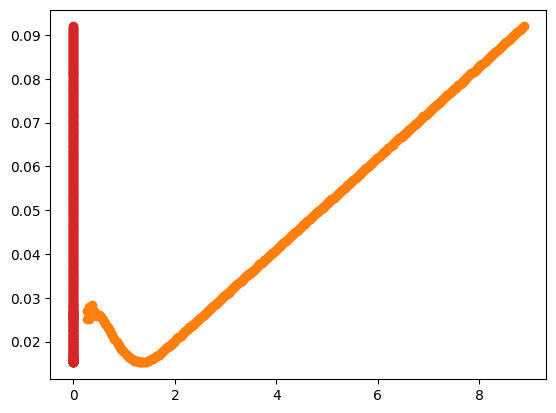

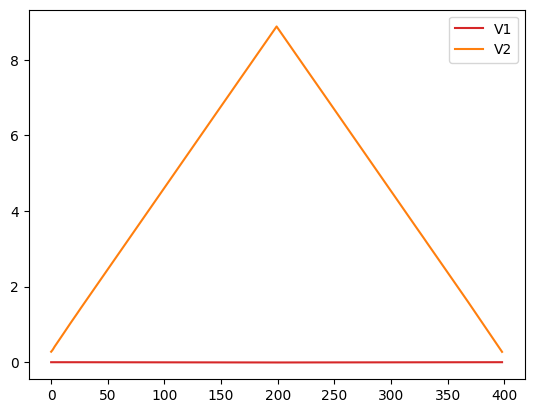

In [15]:
outd = V0_scan_updown(V0max=9, steps=200, sleep=0, nsamples=5)

for i in range(len(edgecomms)):
    plt.scatter(outd['V{}'.format(i+1)], outd.Vr, zorder = -1*i, color=colors[i])
    plt.plot(outd['V{}'.format(i+1)], outd.Vr, zorder = -1*i, color=colors[i])
plt.show()

for i in range(len(edgecomms)):
    plt.plot(outd['V{}'.format(i+1)], label='V{}'.format(i+1), color=colors[i])
plt.legend()

plt.show()

In [12]:
outd['R0'] = R0
outd['V0gain'] = gain
outd['RL1'] = 10e3
outd['RL2'] = 10.5e3
outd['RL3'] = 11e3
outd['RL4'] = 11.5e3
outd['RL5'] = 12e3
outd['RL6'] = 12.5e3
outd['RL7'] = 13e3
outd['RL8'] = 13.5e3
outd['RL9'] = 14e3
for e in edgecomms.itertuples():
    outd['Vg{}'.format(e.edge)] = e.Vgg

outd

NameError: name 'outd' is not defined

In [57]:
outd.to_csv('sequences/9NDR/IVcurve_9.csv')

In [207]:
ul.release_daq_device(in_num)
ul.release_daq_device(out_num)

In [ ]:
outdict